In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import DistanceMetric

# Read test and training data to clean

In [2]:
D_tr = pd.read_csv('.\\data\\train_ctrUa4K.csv', index_col = 0)

Label = D_tr['Loan_Status']
Label = Label.replace({'Y': 1, 'N': 0})
D_tr = D_tr.drop(columns="Loan_Status")
Key_train_full = D_tr.dropna().index
Key_train = D_tr.index

D_te = pd.read_csv('.\\data\\test_lAUu6dG.csv', index_col = 0)
Key_test = D_te.index
Key_test_full = D_te.dropna().index

Data = pd.concat([D_tr, D_te])
print(D_tr.shape)
print(D_te.shape)

print(Data.shape)
print(len(Key_test_full))
print(len(Key_train_full))
Data.describe(include = np.number)

(614, 11)
(367, 11)
(981, 11)
289
480


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,981.000000,981.000000,954.000000,961.000000,902.000000
mean,5179.795107,1601.916330,142.511530,342.201873,0.835920
std,5695.104533,2718.772806,77.421743,65.100602,0.370553
min,0.000000,0.000000,9.000000,6.000000,0.000000
25%,2875.000000,0.000000,100.000000,360.000000,1.000000
50%,3800.000000,1110.000000,126.000000,360.000000,1.000000
75%,5516.000000,2365.000000,162.000000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [3]:
def return_non_intersec(big_set, no_need_set):
    for i in big_set:
        if i not in no_need_set:
            yield i

In [4]:
Key_test_non_full = return_non_intersec(Key_test, Key_test_full)
Key_train_non_full = return_non_intersec(Key_train, Key_train_full)
del D_te
del D_tr

In [5]:
Data = Data.replace({'Male': 0, 'Female': 1, 'Yes': 1, 'No': 0, 'Graduate': 1, 'Not Graduate': 0})
Data.describe(include = 'all')
# for i in DESCRIBE:
#     Data[i] = Data[i]/DESCRIBE.loc['max'][i]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
count,957.000000,978.000000,956,981.000000,926.000000,981.000000,981.000000,954.000000,961.000000,902.000000,981
unique,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Semiurban
freq,NaN,NaN,545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,349
mean,0.190178,0.645194,NaN,0.777778,0.128510,5179.795107,1601.916330,142.511530,342.201873,0.835920,NaN
std,0.392646,0.478699,NaN,0.415952,0.334837,5695.104533,2718.772806,77.421743,65.100602,0.370553,NaN
min,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,9.000000,6.000000,0.000000,NaN
25%,0.000000,0.000000,NaN,1.000000,0.000000,2875.000000,0.000000,100.000000,360.000000,1.000000,NaN
50%,0.000000,1.000000,NaN,1.000000,0.000000,3800.000000,1110.000000,126.000000,360.000000,1.000000,NaN
75%,0.000000,1.000000,NaN,1.000000,0.000000,5516.000000,2365.000000,162.000000,360.000000,1.000000,NaN


# version2

# For discrete columns ==> Hamming distance
Gender, Married, Dependents, Self_Employed, Property_Area, Education

# For continuous columns ==> Euclidian distance
LoanAmount, Loan_Amount_Term, Credit_History, ApplicantIncome, CoapplicantIncome

In [19]:
#not use
def fill_nan(non_nan_dataframe, nan_dataframe, contunuous_col_names, discrete_col_names, distance_names, weights):
    #non_nan_dataframe: dataframe having no NaN
    #nan_dataframe: dataframe to be filled
    #contunuous_col_names: list of column names which contains continuous values
    #discrete_col_names: list of column names which contains discrete values
    #distance_name: list of distance name, choose on from ‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’,
    #               first distance name is for continuous, left is for discrete
    #weights: list of weights weighting each distance
    
    #separate into continuouse and discrete
    
    #continuouse
    non_nan_continuous = non_nan_dataframe[contunuous_col_names]
    nan_continuous = nan_dataframe[contunuous_col_names]
    
    #discrete
    non_nan_discrete = non_nan_dataframe[discrete_col_names]
    nan_discrete = nan_dataframe[discrete_col_names]
    
    for i in nan_continuous.index:
        nan_cols_con = []
        non_nan_cols_con = []
        for j in nan_continuous:
            if np.isnan(nan_continuous.loc[i][j]):
                nan_cols_con.append(j)
            else:
                non_nan_cols_con.append(j)
        con_distances = pairwise_distances(non_nan_continuous[non_nan_cols_con], Y=np.reshape(nan_continuous[non_nan_cols_con],(1,-1)), metric='l2')
        nan_cols_dis = []
        non_nan_cols_dis = []
        for j in nan_discrete:
            if np.isnan(nan_discrete.loc[i][j]):
                nan_cols_dis.append(j)
            else:
                non_nan_cols_dis.append(j)
        dis_distances = pairwise_distances(non_nan_discrete[non_nan_cols_dis], Y=np.reshape(nan_discrete[non_nan_cols_dis],(1,-1)), metric='l2')
        dis = con_distances*weights[0] + dis_distances*weights[1]
        print(np.amax(dis))
        break

In [49]:
#not use
X = Data[['ApplicantIncome','Loan_Amount_Term']].dropna()#np.array([[1,0],[2,2],[1,1]])
Y = Data[['ApplicantIncome','Loan_Amount_Term']].dropna().loc['LP001003']#np.reshape(np.array([1,1]),(1,2))
print(pairwise_distances(X, Y=np.reshape(Y.values,(1,-1)), metric='l2'))

[[1.26600000e+03]
 [0.00000000e+00]
 [1.58300000e+03]
 [2.00000000e+03]
 [1.41700000e+03]
 [8.34000000e+02]
 [2.25000000e+03]
 [1.54700000e+03]
 [5.77000000e+02]
 [8.25800000e+03]
 [1.38300000e+03]
 [2.08300000e+03]
 [1.51000000e+03]
 [2.73000000e+03]
 [3.29275811e+03]
 [3.67000000e+02]
 [9.94268073e+02]
 [1.07300000e+03]
 [3.04000000e+02]
 [3.07700000e+03]
 [1.37200000e+03]
 [1.98300000e+03]
 [1.21800000e+03]
 [8.66000000e+02]
 [4.97700000e+03]
 [1.78400000e+03]
 [3.57000000e+02]
 [3.14100000e+03]
 [8.33000000e+02]
 [4.17000000e+02]
 [1.41600000e+03]
 [1.09000000e+02]
 [1.08300000e+03]
 [7.91700000e+03]
 [2.30800000e+03]
 [9.16000000e+02]
 [4.17000000e+02]
 [8.35000000e+02]
 [9.83000000e+02]
 [2.78300000e+03]
 [2.18300000e+03]
 [6.42000000e+02]
 [1.06600000e+03]
 [1.23800000e+03]
 [1.93800000e+03]
 [5.83000000e+02]
 [2.65500000e+03]
 [1.49700000e+03]
 [3.53000000e+02]
 [3.30000000e+01]
 [6.91700000e+03]
 [1.87500000e+03]
 [2.45100000e+03]
 [1.21700000e+03]
 [3.49700000e+03]
 [1.226000

In [6]:
def clear_nan_dependents (cols):
    if cols[-1] == 1:
        #print('return nul!!')
        return [np.nan, np.nan, np.nan, np.nan, np.nan]
    else:
        return cols

In [19]:
#Data[tmp_non_nan].dropna()
tmp_non_nan

['Gender',
 'Married',
 'Education',
 'Self_Employed',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Dependents_0',
 'Dependents_1',
 'Dependents_2',
 'Dependents_3+',
 'Property_Area_Rural',
 'Property_Area_Semiurban',
 'Property_Area_Urban']

In [7]:
#Convert binary classes to 1 and 0
#Data = Data.replace({'Male': 0, 'Female': 1, 'Yes': 1, 'No': 0, 'Graduate': 1, 'Not Graduate': 0})
#Data.describe(include = 'all')

Distance = 'cosine'

#Encode non binary classes to one hot encoding
Data = pd.get_dummies(Data,prefix=["Dependents", 'Property_Area'],dummy_na = True)
Data[['Dependents_0','Dependents_1','Dependents_2','Dependents_3+', 'Dependents_nan']] = \
Data[['Dependents_0','Dependents_1','Dependents_2','Dependents_3+', 'Dependents_nan']].apply(clear_nan_dependents, axis=1)
Data = Data.drop(['Dependents_nan', 'Property_Area_nan'], axis=1)
Data_non_nan = Data.dropna()

#fill each NaN by the clostest distance
for i in Key_test_non_full:
    print(i)
    tmp_non_nan = []
    tmp_nan = []
    for j in Data:
        if np.isnan(Data.loc[i][j]):
            tmp_nan.append(j)
        else:
            tmp_non_nan.append(j)
    print(tmp_non_nan)
    print(tmp_nan)
    print('-------------------------')
    Name = Data.loc[i][tmp_non_nan].name
    the_most_similar_index = np.argmin(pairwise_distances(Data_non_nan[tmp_non_nan],\
                                                          Y=np.reshape(Data.loc[i][tmp_non_nan].values, (1,-1)), metric=Distance))
    Name = Data_non_nan[tmp_non_nan].iloc[the_most_similar_index].name
    for j in tmp_nan:
        Data.at[i, j] = Data.loc[Name][j]
        
for i in Key_train_non_full:
    print(i)
    tmp_non_nan = []
    tmp_nan = []
    for j in Data:
        if np.isnan(Data.loc[i][j]):
            tmp_nan.append(j)
        else:
            tmp_non_nan.append(j)
    print(tmp_non_nan)
    print(tmp_nan)
    print('-------------------------')
    Name = Data.loc[i][tmp_non_nan].name
    the_most_similar_index = np.argmin(pairwise_distances(Data_non_nan[tmp_non_nan],\
                                                          Y=np.reshape(Data.loc[i][tmp_non_nan].values, (1,-1)), metric=Distance))
    Name = Data_non_nan[tmp_non_nan].iloc[the_most_similar_index].name
    print(Name)
    for j in tmp_nan:
        Data.at[i, j] = Data.loc[Name][j]
    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')

LP001035
['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']
['Credit_History']
-------------------------
LP001059
['Gender', 'Married', 'Education', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']
['Self_Employed']
-------------------------
LP001082
['Gender', 'Married', 'Education', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']
['Self_Employed']
-------------------------
LP001083
['Gender', 'Married', 'Education', 'S

LP002017
['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']
['Credit_History']
-------------------------
LP002045
['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Credit_History', 'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']
['Loan_Amount_Term']
-------------------------
LP002046
['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']
['Credit_History']
-------------------------
LP002057
['Gender', 'Married', 'Education', 'S

['Credit_History']
-------------------------
LP002901
['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']
['Credit_History']
-------------------------
LP002954
['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']
['Credit_History']
-------------------------
LP002965
['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']
['Credit_History']
-------------------------
L

LP002284
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LP001465
['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']
['Credit_History']
-------------------------
LP001878
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LP001469
['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']
['Credit_History']
-------------------------
LP001907
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LP001541
['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Property_Area_Rural', 'Pr

['Married', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']
['Gender']
-------------------------
LP001995
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LP002036
['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']
['Credit_History']
-------------------------
LP001825
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LP002043
['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']
['Credit

['Self_Employed']
-------------------------
LP001872
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LP002501
['Married', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']
['Gender']
-------------------------
LP002731
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LP002502
['Gender', 'Married', 'Education', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']
['Self_Employed']
-------------------------
LP001722
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LP002522
['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Dependents_0', 'Dependents_1', 'Dependents_2',

In [8]:
Data.describe()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
count,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000
mean,0.190622,0.644241,0.777778,0.123344,5179.795107,1601.916330,143.202854,342.014271,0.836901,0.570846,0.165138,0.170234,0.093782,0.295617,0.355759,0.348624
std,0.392992,0.478987,0.415952,0.328999,5695.104533,2718.772806,78.190562,65.490643,0.369644,0.495208,0.371494,0.376030,0.291674,0.456552,0.478987,0.476778
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,2875.000000,0.000000,100.000000,360.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,3800.000000,1110.000000,127.000000,360.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,5516.000000,2365.000000,162.000000,360.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,81000.000000,41667.000000,700.000000,480.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Hand crafted features
1. LA/(AC+CC)
2. LAT/(AC+CC)

In [16]:
def create_feature1(cols):
    LA = cols[0]
    AC = cols[1]
    CC = cols[2]
    return LA/(AC + CC)

def create_feature2(cols):
    LAT = cols[0]
    AC = cols[1]
    CC = cols[2]
    return LAT/(AC + CC)

In [17]:
Data['feature1'] = Data[['LoanAmount', 'ApplicantIncome', 'CoapplicantIncome']].apply(create_feature1, axis = 1)
Data['feature2'] = Data[['Loan_Amount_Term', 'ApplicantIncome', 'CoapplicantIncome']].apply(create_feature2, axis = 1)

# Dividing train and test

In [18]:
DESCRIBE = Data.describe(include = np.number)
for i in DESCRIBE:
    Data[i] = Data[i]/DESCRIBE.loc['max'][i]  

#Divide training and test set
Train = Data.loc[Key_train]
Train = pd.merge(Train, Label, on='Loan_ID')#merge the labels back
Test = Data.loc[Key_test]
print(Train.shape)
print(Test.shape)
Test.describe()

(614, 19)
(367, 18)


,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,feature1,feature2
count,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000
mean,0.196185,0.634877,0.771117,0.103542,0.059328,0.037670,0.195232,0.712511,0.833787,0.561308,0.163488,0.166213,0.108992,0.302452,0.316076,0.381471,0.238748,0.273298
std,0.397652,0.482122,0.420687,0.305082,0.060626,0.056021,0.088366,0.138158,0.372780,0.496905,0.370315,0.372780,0.312054,0.459947,0.465578,0.486411,0.091139,0.129595
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.012500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018624,0.004414
25%,0.000000,0.000000,1.000000,0.000000,0.035358,0.000000,0.143571,0.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.190907,0.190703
50%,0.000000,1.000000,1.000000,0.000000,0.046741,0.024600,0.178571,0.750000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.237313,0.262612
75%,0.000000,1.000000,1.000000,0.000000,0.062469,0.058332,0.225714,0.750000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.280793,0.339534
max,1.000000,1.000000,1.000000,1.000000,0.895420,0.575995,0.785714,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.849985


In [19]:
#Save V3
Test.to_csv(f'.\\data\\Test_v4_{Distance}_with_handcrafted_features1_2.csv')
Train.to_csv(f'.\\data\\Train_v4_{Distance}_with_handcrafted_features1_2.csv')

# Plot and see data distributions

Gender  Married
Female  No         124
        Yes         57
Male    Yes        561
        No         212
Name: Married, dtype: int64
   Gender Married  percentage
0  Female      No   68.508287
1  Female     Yes   31.491713
2    Male     Yes   72.574386
3    Male      No   27.425614


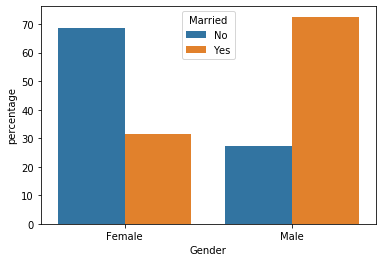

In [28]:
Data2 = Data.groupby(['Gender'])['Married'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
#sns.countplot(x="Married", hue="percentage", data=Data2)
p = sns.barplot(x="Gender", y="percentage", hue="Married", data=Data2)
print(Data.groupby(['Gender'])['Married'].value_counts().head())
print(Data2.head())

0.8181818181818182
0.38569460791993504
(165,)


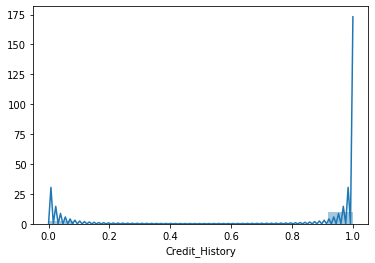

In [23]:
sns.distplot(Data[Data["Gender"] == 'Female']['Credit_History'].dropna())
print(np.mean(Data[Data["Gender"] == 'Female']['Credit_History'].dropna()))
print(np.std(Data[Data["Gender"] == 'Female']['Credit_History'].dropna()))
print(Data[Data["Gender"] == 'Female']['Credit_History'].dropna().shape)

0.8417366946778712
0.3649877141913731
(714,)


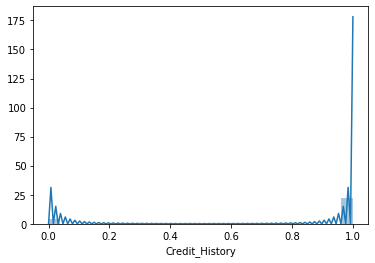

In [24]:
sns.distplot(Data[Data["Gender"] == 'Male']['Credit_History'].dropna())
print(np.mean(Data[Data["Gender"] == 'Male']['Credit_History'].dropna()))
print(np.std(Data[Data["Gender"] == 'Male']['Credit_History'].dropna()))
print(Data[Data["Gender"] == 'Male']['Credit_History'].dropna().shape)

342.2018730489074
65.06672183179369
(961,)


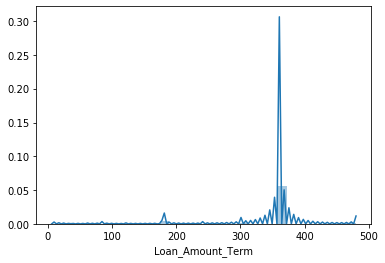

In [29]:
sns.distplot(Data['Loan_Amount_Term'].dropna())
print(np.mean(Data['Loan_Amount_Term'].dropna()))
print(np.std(Data['Loan_Amount_Term'].dropna()))
print(Data['Loan_Amount_Term'].dropna().shape)

339.9366754617414
67.15214246786147
(758,)


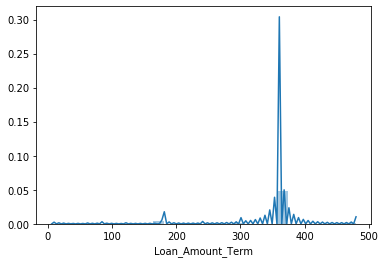

In [20]:
sns.distplot(Data[Data["Gender"] == 'Male']['Loan_Amount_Term'].dropna())
print(np.mean(Data[Data["Gender"] == 'Male']['Loan_Amount_Term'].dropna()))
print(np.std(Data[Data["Gender"] == 'Male']['Loan_Amount_Term'].dropna()))
print(Data[Data["Gender"] == 'Male']['Loan_Amount_Term'].dropna().shape)

351.75418994413405
56.388377123509585
(179,)


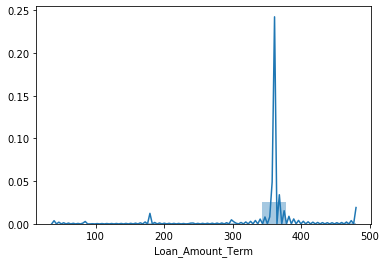

In [19]:
sns.distplot(Data[Data["Gender"] == 'Female']['Loan_Amount_Term'].dropna())
print(np.mean(Data[Data["Gender"] == 'Female']['Loan_Amount_Term'].dropna()))
print(np.std(Data[Data["Gender"] == 'Female']['Loan_Amount_Term'].dropna()))
print(Data[Data["Gender"] == 'Female']['Loan_Amount_Term'].dropna().shape)

142.51153039832286
77.38115506022463
(954,)


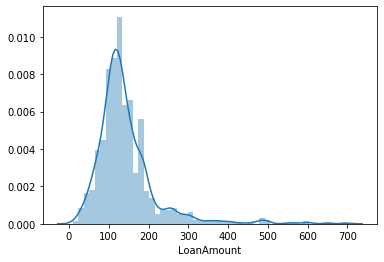

In [28]:
sns.distplot(Data['LoanAmount'].dropna())
print(np.mean(Data['LoanAmount'].dropna()))
print(np.std(Data['LoanAmount'].dropna()))
print(Data['LoanAmount'].dropna().shape)

126.73595505617978
72.41285308219527
(178,)


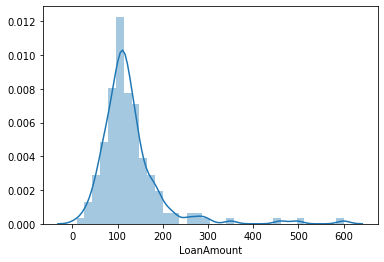

In [21]:
sns.distplot(Data[Data["Gender"] == 'Female']['LoanAmount'].dropna())
print(np.mean(Data[Data["Gender"] == 'Female']['LoanAmount'].dropna()))
print(np.std(Data[Data["Gender"] == 'Female']['LoanAmount'].dropna()))
print(Data[Data["Gender"] == 'Female']['LoanAmount'].dropna().shape)

145.4281914893617
75.78865598130564
(752,)


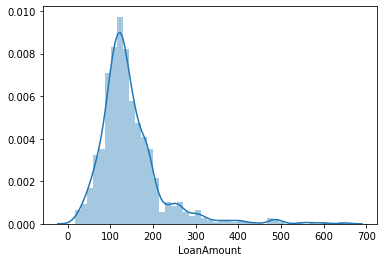

In [22]:
sns.distplot(Data[Data["Gender"] == 'Male']['LoanAmount'].dropna())
print(np.mean(Data[Data["Gender"] == 'Male']['LoanAmount'].dropna()))
print(np.std(Data[Data["Gender"] == 'Male']['LoanAmount'].dropna()))
print(Data[Data["Gender"] == 'Male']['LoanAmount'].dropna().shape)

5256.925161290323
5835.047851273992
(775,)


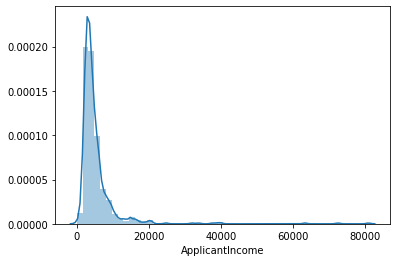

In [25]:
sns.distplot(Data[Data["Gender"] == 'Male']['ApplicantIncome'].dropna())
print(np.mean(Data[Data["Gender"] == 'Male']['ApplicantIncome'].dropna()))
print(np.std(Data[Data["Gender"] == 'Male']['ApplicantIncome'].dropna()))
print(Data[Data["Gender"] == 'Male']['ApplicantIncome'].dropna().shape)

4458.906593406594
3247.5673358939484
(182,)


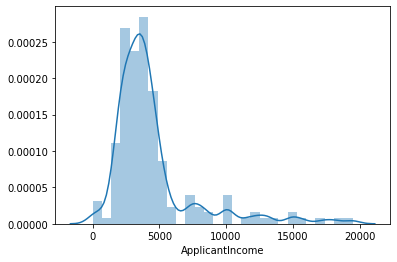

In [26]:
sns.distplot(Data[Data["Gender"] == 'Female']['ApplicantIncome'].dropna())
print(np.mean(Data[Data["Gender"] == 'Female']['ApplicantIncome'].dropna()))
print(np.std(Data[Data["Gender"] == 'Female']['ApplicantIncome'].dropna()))
print(Data[Data["Gender"] == 'Female']['ApplicantIncome'].dropna().shape)

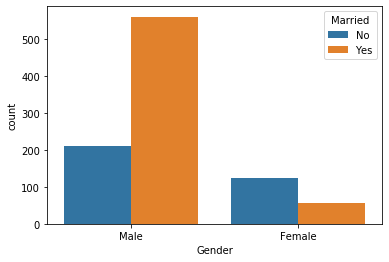

In [94]:
sns.countplot(x="Gender", hue="Married", data=Data)

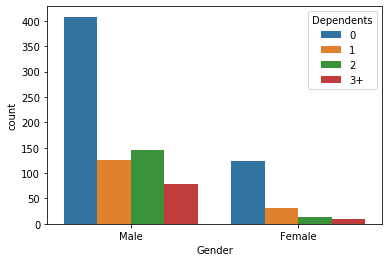

In [74]:
sns.countplot(x="Gender", hue="Dependents", data=Data)

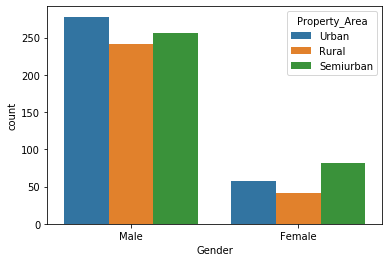

In [80]:
sns.countplot(x="Gender", hue="Property_Area", data=Data)

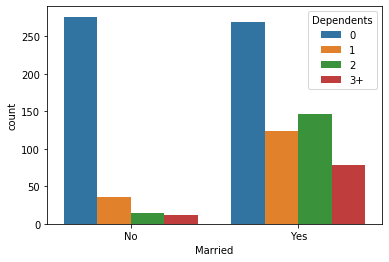

In [81]:
sns.countplot(x="Married", hue="Dependents", data=Data)

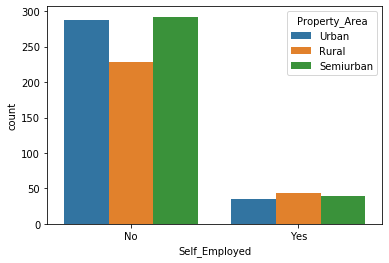

In [90]:
sns.countplot(x="Self_Employed", hue="Property_Area", data=Data)

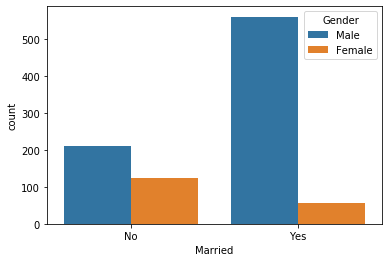

In [96]:
sns.countplot(x="Married", hue="Gender", data=Data)